In [9]:
!pip install pyspark==3.1.1
!pip install matplotlib
!pip install pandas

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, ArrayType
import matplotlib.pyplot as plt
import pandas as pd


In [19]:
spark = SparkSession\
    .builder\
    .appName("openweather_transformation")\
    .getOrCreate()

In [20]:
df = spark.read.json("../../datalake/openweather")

In [21]:
df.show()

+-----------+----------+--------+----------+-----------+-------------+--------+--------------------+------+------+----------------+------------+
|cloud_cover|      date|humidity|       lat|        lon|precipitation|pressure|         temperature|    tz| units|            wind|extract_data|
+-----------+----------+--------+----------+-----------+-------------+--------+--------------------+------+------+----------------+------------+
|    {100.0}|2023-11-20|  {39.0}|-16.680882|-49.2532691|      {12.24}|{1011.0}|{32.32, 26.65, 34...|-03:00|metric|{{120.0, 10.29}}|  2023-11-20|
|    {100.0}|2023-12-05|  {42.0}|-16.680882|-49.2532691|      {23.06}|{1014.0}|{32.25, 21.83, 33...|-03:00|metric|{{320.0, 11.83}}|  2023-12-05|
|     {47.0}|2024-03-30|  {59.0}|-16.680882|-49.2532691|      {11.25}|{1014.0}|{29.78, 21.83, 30...|-03:00|metric|{{280.0, 10.29}}|  2024-03-30|
|    {100.0}|2024-02-07|  {77.0}|-16.680882|-49.2532691|      {10.01}|{1015.0}|{23.77, 24.86, 27...|-03:00|metric| {{189.0, 2.11}}

In [22]:
df.printSchema()

root
 |-- cloud_cover: struct (nullable = true)
 |    |-- afternoon: double (nullable = true)
 |-- date: string (nullable = true)
 |-- humidity: struct (nullable = true)
 |    |-- afternoon: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- precipitation: struct (nullable = true)
 |    |-- total: double (nullable = true)
 |-- pressure: struct (nullable = true)
 |    |-- afternoon: double (nullable = true)
 |-- temperature: struct (nullable = true)
 |    |-- afternoon: double (nullable = true)
 |    |-- evening: double (nullable = true)
 |    |-- max: double (nullable = true)
 |    |-- min: double (nullable = true)
 |    |-- morning: double (nullable = true)
 |    |-- night: double (nullable = true)
 |-- tz: string (nullable = true)
 |-- units: string (nullable = true)
 |-- wind: struct (nullable = true)
 |    |-- max: struct (nullable = true)
 |    |    |-- direction: double (nullable = true)
 |    |    |-- speed: double (nullable = tru

In [28]:
df_weather = df.select(
    col("date"),
    col("cloud_cover").getItem("afternoon").alias("cloud_cover_afternoon"),
    col("humidity").getItem("afternoon").alias("humidity_afternoon"),
    col("precipitation").getItem("total").alias("precipitation_total"),
    col("temperature").getItem("max").alias("temp_max"),
    col("temperature").getItem("min").alias("temp_min"),
    col("temperature").getItem("afternoon").alias("temp_afternoon"),
    col("temperature").getItem("evening").alias("temp_evening"),
    col("temperature").getItem("morning").alias("temp_morning"),
    col("temperature").getItem("night").alias("temp_night"),
    col("pressure").getItem("afternoon").alias("pressure_afternoon"),
    col("wind").getItem("max").getField("speed").alias("wind_speed_max"),
    col("wind").getItem("max").getField("direction").alias("wind_direction_max")
)

df_weather.show(20, truncate=False)

+----------+---------------------+------------------+-------------------+--------+--------+--------------+------------+------------+----------+------------------+--------------+------------------+
|date      |cloud_cover_afternoon|humidity_afternoon|precipitation_total|temp_max|temp_min|temp_afternoon|temp_evening|temp_morning|temp_night|pressure_afternoon|wind_speed_max|wind_direction_max|
+----------+---------------------+------------------+-------------------+--------+--------+--------------+------------+------------+----------+------------------+--------------+------------------+
|2023-11-20|100.0                |39.0              |12.24              |34.68   |20.83   |32.32         |26.65       |20.89       |22.83     |1011.0            |10.29         |120.0             |
|2023-12-05|100.0                |42.0              |23.06              |33.09   |19.79   |32.25         |21.83       |20.07       |21.31     |1014.0            |11.83         |320.0             |
|2024-03-30|47.

In [29]:
df_weather.coalesce(1).write.mode("overwrite").json('output/weather')

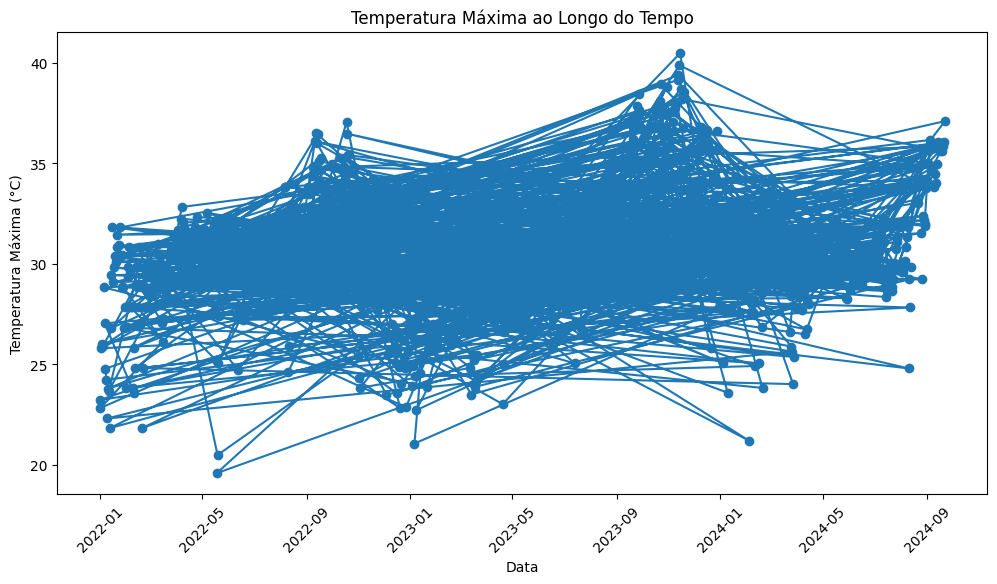

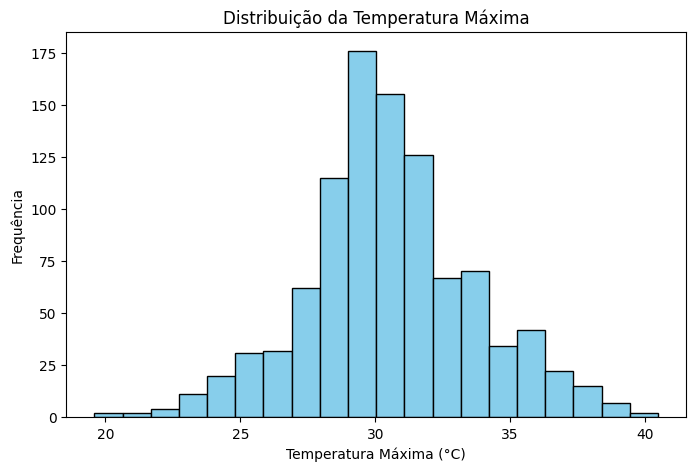

In [27]:
# Converter para Pandas para visualização
df_pandas = df_weather.toPandas()

# Plotar a temperatura máxima ao longo do tempo
plt.figure(figsize=(12,6))
plt.plot(pd.to_datetime(df_pandas['date']), df_pandas['temp_max'], marker='o')
plt.xlabel('Data')
plt.ylabel('Temperatura Máxima (°C)')
plt.title('Temperatura Máxima ao Longo do Tempo')
plt.xticks(rotation=45)
plt.show()

# Histograma da temperatura máxima
plt.figure(figsize=(8,5))
plt.hist(df_pandas['temp_max'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Temperatura Máxima (°C)')
plt.ylabel('Frequência')
plt.title('Distribuição da Temperatura Máxima')
plt.show()